In [61]:
from numpy import ndarray, vectorize

class TaxCalculator:
    #rates are in local currency for the region, for 2021-2022
    # https://www.ato.gov.au/rates/individual-income-tax-rates/
    aus_rates = {0: 0, 18200:.19, 30000:.19+.02, 45000:.325+0.02, 97000:.325+0.02+0.01, 113000:.325+0.02+0.015,  120000:.37+0.02, 151000:.37+.02+.0125, 180000:.45+0.02}
    # welfare in fortnightly amounts
    job_seeker_payment = 749.20
    jobseeker_tax = {0:0, 150:.5, 256:.6, 1431:1}
    rent_assistance_payment = 184.80
    rent_assistance_tax = {0:0, 1431:1}
    hecs_tax = {0: 0,
                51550: 0.01,
                59518: 0.02,
                63089: 0.025,
                66875: 0.03,
                70888: 0.035,
                75140: 0.04,
                79649: 0.045,
                84429: 0.05,
                89494: 0.055,
                94865: 0.06,
                100557: 0.065,
                106590: 0.07,
                112985: 0.075,
                119764: 0.08,
                126950: 0.085,
                134568: 0.09,
                142642: 0.095,
                151200: 0.1}

    
    tax_rates_of = {"Australia":aus_rates}
    
    # google on 10/6/22
    usd_exchange_rate_of = {"Australia": 0.65}
    
    def __init__(self, country):
        try:
            self.tax_rates = self.tax_rates_of[country]
            self.usd_rate = self.usd_exchange_rate_of[country]
        except KeyError:
            raise Exception("Country not supported!")
        
    def usd(self, income):
        return income/self.usd_rate
    
    def tax_on_usd_vector(self, income: ndarray):
        return vectorize(self.tax_on_usd)(income)
        
    def tax_on_usd(self, income: float):
        return self.tax_with_wellfare(income/self.usd_rate)*self.usd_rate
    
    def tax_generic(self, income, rates):

        tax = 0
        while income > 0:
            # find largest bracket which is smaller than income
            applicable_tax_bracket = 0
            for tax_bracket in rates.keys():
                if tax_bracket >= income:
                    break
                applicable_tax_bracket = tax_bracket

            tax += (income-applicable_tax_bracket)*rates[applicable_tax_bracket]
            income = applicable_tax_bracket
        return tax
    
    def tax(self, income):
        return self.tax_generic(income, self.tax_rates)
    
    def tax_with_wellfare(self, income):
        welfare_income = max(0, 356/14*(self.job_seeker_payment - self.tax_generic(income*14/365, self.jobseeker_tax)))
        rent_asst_income = max(0, 356/14*(self.rent_assistance_payment - self.tax_generic(income*14/365, self.rent_assistance_tax)))
        adjusted_income = income + welfare_income + rent_asst_income
        return self.tax(adjusted_income)

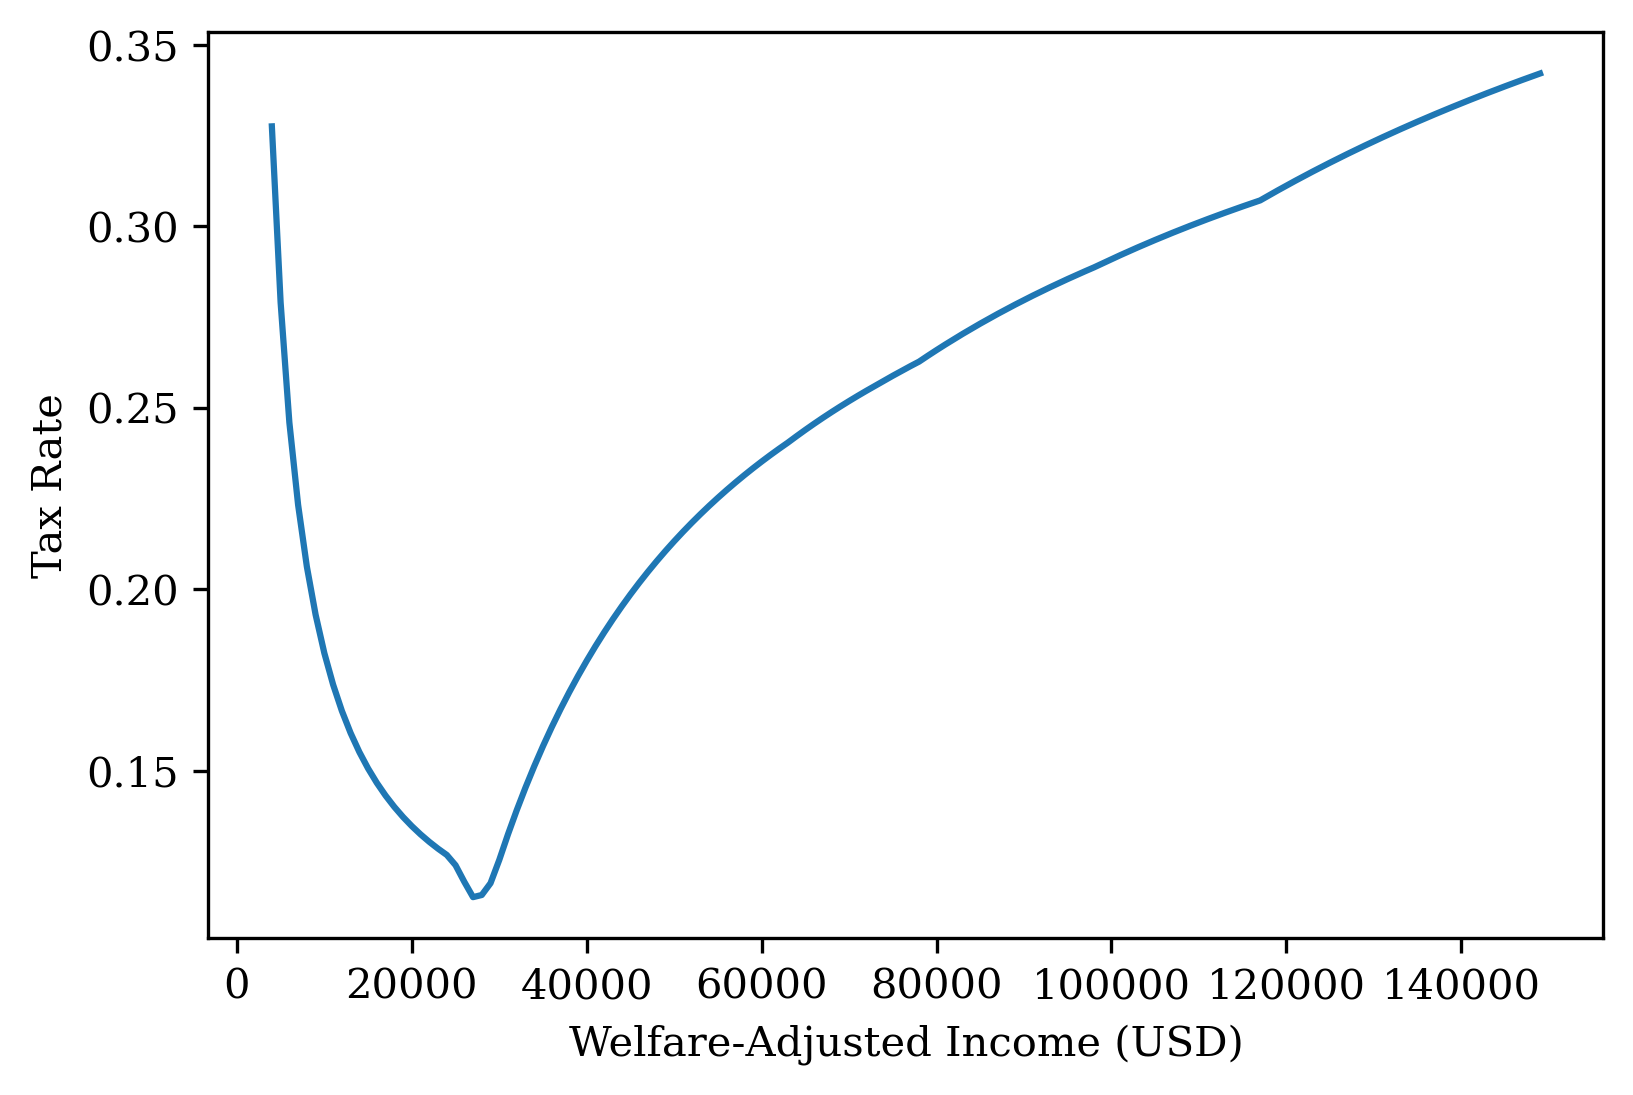

In [62]:
from matplotlib import pyplot as plt, rcParams
rcParams['figure.dpi'] = 300
rcParams['text.usetex'] = False

from numpy import arange
usd_income = arange(4000, 150000, 1000)

for country in ["Australia"]:
    calculator = TaxCalculator(country)
    
    tax_usd = calculator.tax_on_usd_vector(usd_income)
        
    plt.plot(usd_income, (tax_usd)/usd_income, label=country)

plt.xlabel("Welfare-Adjusted Income (USD)")
plt.ylabel("Tax Rate")
plt.savefig("middle-high-incomes")

In [63]:
calculator = TaxCalculator("Australia")
calculator.tax_with_wellfare(108000)

27237.0